# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD9 : Régression bayésienne

La régression ridge est un cas particulier de la régression linéaire bayésienne lorsque la loi *a priori* partiellement informative suivante est utilisée :

$$ f_{(\boldsymbol{\beta},\sigma^2)}(\boldsymbol{\beta},\sigma^2) \propto \mathcal{N}\left(\boldsymbol{\beta} \, \left| \, \boldsymbol{0}_p , \frac{\sigma^2}{\lambda}I_p \right. \right) \times \frac{1}{\sigma^2}. $$

Pour être conséquent avec l'approche bayésienne, il faudrait fixer l'hyperparamètre $\lambda$ avant même d'avoir vu les données. De façon pragmatique, la valeur de $\lambda$ est souvent choisie par validation comme nous le ferons dans cet exercice.

## Données

Le jeu de données étudiées pour l'exercice 1 provient de l'étude de Tibshirani et al. (2004) illustrant les méthodes de régression modernes telle que la régression ridge. Nous étudierons la glycémie sanguine (glu) en fonction de 8 variables explicatives : l'âge du patient (age), l'indice de masse corporel du patient (bmi), de la tension artérielle moyenne (map) ainsi que de 5 autres indicateur sanguins (tc, ldl, hdl, tch et ltg). Nous laissons tomber dans le cadre de ce TD le sexe du patient et la variable prog.


#### Référence
Tibshirani, R. J., Johnstone, I., Hastie, T., & Efron, B. (2004). Least angle regression. *The Annals of Statistics*, 32(2), 407–499. DOI:10.1214/009053604000000067


In [1]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using Statistics
import StatsBase

## Chargement des données

In [2]:
data = CSV.read("diabetes.csv", DataFrame)
select!(data, Not([:prog, :sex]))
first(data,5)

,age,bmi,map,tc,ldl,hdl,tch,ltg,glu
,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,59,32.1,101.0,157,93.2,38.0,4.0,2.11,87
2,48,21.6,87.0,183,103.2,70.0,3.0,1.69,69
3,72,30.5,93.0,156,93.6,41.0,4.0,2.03,85
4,24,25.3,84.0,198,131.4,40.0,5.0,2.12,89
5,50,23.0,101.0,192,125.4,52.0,4.0,1.86,80


## Création de l'ensemble d'entraînement et de validation

In [3]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

,age,bmi,map,tc,ldl,hdl,tch,ltg,glu
,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,59,32.1,101.0,157,93.2,38.0,4.0,2.11,87
2,23,22.6,89.0,139,64.8,61.0,2.0,1.82,68
3,56,28.0,85.0,184,144.8,32.0,6.0,1.56,77
4,61,32.0,103.7,210,85.2,35.0,6.0,2.65,124
5,31,29.7,88.0,167,103.4,48.0,4.0,1.89,78
6,30,25.2,83.0,178,118.4,34.0,5.0,2.11,83
7,63,24.4,73.0,160,91.4,48.0,3.0,2.01,78
8,58,38.0,103.0,150,107.2,22.0,7.0,2.02,98
9,48,33.0,123.0,253,163.6,44.0,6.0,2.36,97


## Estimation des paramètres de standardisation des variables

Paramètres estimés avec l'ensemble d'entraînement.

In [4]:
# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(train))

X = transdata[:,1:8]
y = transdata[:,9]

n = length(y)
m = size(X,2)

8

# Exercice 1 : Régression Ridge

### (a) Estimez les coefficients de régression Ridge en utilisant $\lambda = 0$.

In [5]:
λ = 0.  # on défini lambda

β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.

8-element Vector{Float64}:
  0.11326783945740848
  0.14179792077516368
  0.18379469462912895
 -0.20138898260709256
  0.15545146117410555
  0.14216212815427506
  0.2193976137923752
  0.2629889464437398

### (b) Estimez les coefficients de régression Ridge en utilisant $\lambda = 1$.

In [6]:
λ = 1
β̂ = (X'X + λ*I)\X'y

8-element Vector{Float64}:
  0.11350929863960374
  0.14154648072374149
  0.18351774284665842
 -0.129052786433824
  0.09894037023612802
  0.10707247995340377
  0.20768892763109742
  0.2379834517229776

### (c) Pour $0 \leq \lambda \leq 10$, estimez les coefficients de régression puis affichez-les en fonction de $\lambda$.

Ce graphique s'appelle la trace des coefficients de régression. Lorsqu'il y a multicolinéarité, les estimations des coefficients de régression varient beaucoup en fonction de $\lambda$.

Je vous propose de remplir la matrice $\hat\beta$ constituée de $p$ colonnes. Chaque ligne correspondra aux estimations des coefficients de régression pour une valeur de $\lambda$ donnée. Cette matrice sera par la suite transformée en DataFrame pour un affichage simplifié.

In [7]:
df = DataFrame(λ = Float64[],          # Création d'un DataFrame vide dans lequel on va stocker les résultats
               Paramètre = String[],
               Estimation = Float64[])

coefs = ["β₁","β₂","β₃","β₄","β₅","β₆","β₇","β₈"]  # (va servir à dinstinguer les résultats par couleurs...)

for λ = 0:0.01:10  # pour chaque valeur de lambda entre 0 et 10
    
    β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.
    
    for i = 1:m  # Pour chaque paramètres (β1 à β8)
        push!(df, [λ, coefs[i], β̂[i]])  # on stocke les résultats dans notre df 
    end
end

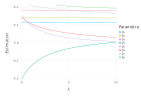

In [8]:
plot(df,    # le dataframe des résultats
    x = :λ,    # l'axe des x (nos lambdas de 0 à 10)
    y = :Estimation,  # la valeur des betas
    color = :Paramètre,  # chaque couleur est un beta
    Geom.line,
    Coord.cartesian(ymin=-0.2, ymax=0.2))  # le type de graphique (lignes dans ce cas-ci)

### (d) Estimez λ en minisant l'erreur de prédiction sur l'échantillon de validation

In [9]:
# on va minimiser l'erreur de préd. sur l'échantillon de VALIDATION
# Il faut standardiser ces données aussi ! (comme ça été fait pour l'ensemble d'entraînement)

#dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train), dims=1) (dt = les params. de standardisation)
transdata = StatsBase.transform(dt, Matrix{Float64}(valid))

X_valid = transdata[:,1:8]
y_valid = transdata[:,9];

In [10]:
df = DataFrame(λ = Float64[], rmse = Float64[])

for λ = 0:0.01:50
    β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.
    
    ŷ = X_valid*β̂  # on fait une prédiction (comme avant) avec les données de test
    
    rmse = StatsBase.rmsd(ŷ, y_valid)  # on calcul le rmse (avec StatsBase...)
    
    push!(df, [λ, rmse])  # maintenant, il faut stocker ces résultats dans notre dataframe :
end

In [11]:
λ̂ = df.λ[argmin(df.rmse)]  # On vient trouver le lambda correspondant au plus petit rmse  (armgmin donne l'indice)

35.39

In [12]:
plot(df, x=:λ, y=:rmse, Geom.line);  # on voit que 6.73 est un minimum 

### (e) Tracez la loi *a posteriori* marginale du coefficient de régression correspond à la variable *age*.

Est-ce que cette variable possède un pouvoir prédictif significatif ? 

Utiliser la commande `LocationScale(μ, sqrt(Σ), TDist(ν))` pour créer un objet de type *loi de Student multidimensionnelle à ν degrés de liberté, de paramètre de localisation μ et de paramètre d'échelle Σ*.

In [13]:
β̂ = (X'X + I*λ̂)\X'y;  # on calcule les coefs pour le lambda optimal λ̂

In [14]:
# On a besoin des résidus pour calculer σ̂²
ŷ = X*β̂  # donc on fait une prédiction
e = y-ŷ  # puis on calcule l'erreur
σ̂² = dot(e,e)/n  # on profite dot product ici...

0.6912819517847649

In [15]:
sum((y.-ŷ).^2)/n  # ...ça revient au même

0.6912819517847649

In [16]:
Σ = σ̂²*inv(X'X + λ̂*I)  # on calcule la matrice Σ

pd = LocationScale(β̂[1], sqrt(Σ[1,1]), TDist(n-m))  # on crée l'objet de type loi de student multidim à ν ddl

# ici, la fonction LocationScale() permet de rajouter un param. de localisation μ et un param. d'échelle Σ
# à la loi TDist(n-m)

LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.10993692021383625
σ: 0.045672706940036
ρ: TDist{Float64}(ν=346.0)
)


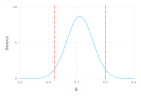

In [17]:
plot(x->pdf(pd,x), -.1, .3,  # pour l'affichage de la dist, on doit d'abord l'évaluer en tout points entre -.1 et .3
    # ↑ évalue la densité de probabilité de pd, entre -.1 et .3
    xintercept = quantile.(pd, [.025, .975]), Geom.vline(style=:dash, color="red"),  # pour afficher les intervalles
    Guide.xlabel("β₁"), Guide.ylabel("Densité"))

### (f) Implémentez l'échantillonnage de Gibbs pour générer un échantillon de la loi *a posteriori* de la régression ridge.

Utilisez votre estimation λ̂.

In [18]:
# Ici je suis allé chercher les équations 7.12 et 7.13 du chap. 7

# Loi cond. de β
f₁(σ²::Real) = MvNormal(β̂, σ²*Symmetric(inv(X'X + λ̂*I))) # MvNormal = multivariate normal (multi dim!)
# Ici, inv(X'X + λ̂*I) est déjà symétrique mais on a besoin de Symmetric à cause des petits différences numériques 

# Loi cond. de σ²
f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*λ̂*β'β) 


### Échantillonage de Gibbs
niter = 1000 

# Initialisation des arrays pour β et σ²
β = Array{Float64}(undef, 8, niter)  
σ² = Array{Float64}(undef, niter)

# Définition des conditions de départ pour Gibbs
β[:,1] = zeros(8)
σ²[1] = 0.005;

# Boucle de 2 à 1000
for j in 2:niter   
    β[:,j] = rand(f₁(σ²[j-1]))    # on tire une valeur pour β à partir de σ² de l'itération j-1
    σ²[j] = rand(f₂(β[:,j]))      # on tire une valeur pour σ² à partir de β de l'itération j
end

# L'ordre n'a pas d'importance dans l'échantillonage de Gibbs
#for j in 2:niter 
#    σ²[j] = rand(f₂(β[:,j-1]))      # on tire une valeur pour σ² à partir de β de l'itération j-1
#    β[:,j] = rand(f₁(σ²[j]))    # on tire une valeur pour β à partir de σ² de l'itération j
#end

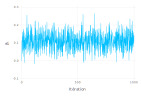

In [19]:
# On trace la chaîne pour β₁
fig = plot(y=β[1,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₁"))

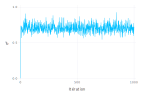

In [20]:
# On trace la chaîne pour σ²
fig = plot(y=σ², Geom.line, Guide.xlabel("Itération"), Guide.ylabel("σ²"))

In [21]:
# Retrait des itérations de chauffe (j'aurais aussi pu utiliser deleteat!(β, 1:100) sinon)
β = β[:, 101:end]
σ² = σ²[101:end];

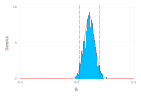

In [22]:
# superposition de la densité à postériori à l'histogramme des betas1 généré par Gibbs
plot(
    layer(x->pdf(pd,x), -.5, .5, Theme(default_color=colorant"red"),  # le layer pour la densité
            # ↑ évalue la densité de probabilité de pd, entre -.5 et .5
    xintercept = quantile.(pd, [.025, .975]), Geom.vline(style=:dash, color="red")),  # les lignes pointillés (intervalles)
    Guide.xlabel("β₁"), Guide.ylabel("Densité"),
    
    layer(x=β[1,:], Geom.histogram(density=true, bincount=30)) # le layer pour l'histogramme (densité=true pour l'échelle)
) 

## Exercice 2 : Exploration stochastique de l'espace des modèles [OPTIONEL]

Dans cet exercice, on reprend le jeux de données *bodyfat.csv* comportant le pourcentage de gras de 20 patientes en fonction des variables explicatives suivantes :

$x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
$x_2$ : le tour de cuisse (en mm) ;<br/>
$x_3$ : la circonférence du bras en (mm).<br/>

Nous allons implémenter l'échantillonnage de Gibbs pour explorer de façon stochastique l'espace des modèele. Puisqu'il n'y a que 3 variables explicatives dans ce cas-ci, il est possible de déterminer quel est le *vrai* meilleur modèle par énumération complète de tous les modèles.


In [23]:
# Chargement des données

data = CSV.read("bodyfat.csv", DataFrame)
first(data, 5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


In [24]:
# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(data), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(data))

X = transdata[:,1:3]
y = transdata[:,4]

n = length(y)
m = size(X,2)

3

In [25]:
# Énumration de tous les modèles possibles

itr = reverse.(Iterators.product(fill(0:1,m)...))[:]

M = BitArray[]
for i in eachindex(itr)
   push!(M, [itr[i]...] .== 1)
end
M

8-element Vector{BitArray}:
 [0, 0, 0]
 [0, 0, 1]
 [0, 1, 0]
 [0, 1, 1]
 [1, 0, 0]
 [1, 0, 1]
 [1, 1, 0]
 [1, 1, 1]

### (a) Écrivez une fonction permettant de calculer le BIC d'un modèle.

La fonction devrait prendre comme argument un vecteur de booléens indicant quelles variables sont incluses dans le modèle. La fonction devrait prendre en argument par exemple le vecteur [true true true].

In [26]:
function getbic(γ::BitArray)
    
    if any(γ)
    
        Xᵧ = X[:,γ]

        β̂ = (Xᵧ'Xᵧ)\Xᵧ'y

        μ̂ = Xᵧ*β̂

        e = y-μ̂

        σ̂² = dot(e,e)/(n-m) 

        BIC = sum(logpdf.(Normal.(μ̂,sqrt(σ̂²)),y)) - (count(γ)+1)/2*log(n)
        
    else
        
        σ̂² = dot(y,y)/(n-m)
        
        BIC = sum(logpdf.(Normal.(0,sqrt(σ̂²)),y)) - (count(γ)+1)/2*log(n)
        
    end
    
    return BIC
    
end

getbic (generic function with 1 method)

### (b) Calculer le BIC pour chacun des modèles possibles

Quel est le meilleur modèle ?

In [27]:
BIC = getbic.(M)

8-element Vector{Float64}:
 -29.488893151972693
 -30.78176951264226
 -16.244618147055984
 -17.536369508313587
 -18.570129722290112
 -17.05936046854954
 -17.43151125814423
 -17.819953137176935

In [28]:
_, ind = findmax(BIC)
M[ind]

3-element BitVector:
 0
 1
 0

### (c) Exécuter la cellule suivante pour parcourir l'espace des modèles avec l'échantillonnage de Gibbs

In [29]:
function softmax(x::AbstractVector{<:Real})
    
    z = x .- maximum(x)
    
    e = exp.(z)
    
    s = e ./ sum(e)
    
end

softmax (generic function with 1 method)

In [30]:
niter = 10000

γ = trues(3,niter)

for i=2:niter
   γ[:,i] = γ[:,i-1]
    for j=1:m
        
        η₀ = γ[:,i]
        η₁ = γ[:,i]
        η₀[j] = false
        η₁[j] = true
        
        #θ = exp(getbic(η₁)) / ( exp(getbic(η₀)) + exp(getbic(η₁)))
        s = softmax(getbic.([η₀, η₁])) # évite l'instabilité numérique
        θ = s[2]
        
        γ[j,i] = rand(Bernoulli(θ))
        
    end
end

### (d) Exécuter les cellules suivantes pour déterminer le modèle choisi pour chacune des itérations

In [31]:
function modelid(M::Vector{BitArray},γ::BitArray)
    
    @assert length(γ)==length(M[1])
    
    ind = 1
    
    while M[ind] != γ
        ind +=1
    end
    
    return ind
        
end

modelid (generic function with 1 method)

In [32]:
id = [modelid(M,γ[:,i]) for i=1:size(γ,2)]

df = DataFrame(Itération = 1:niter, Modèle = id)

groupby(df, :Modèle)

nb = combine(groupby(df, :Modèle), :Itération=> length => :Itérations)

sort!(nb, :Itérations, rev=true)

,Modèle,Itérations
,Int64,Int64
1,3,4303
2,6,1965
3,7,1273
4,4,1176
5,8,868
6,5,415


### (e) Selon les résultats en (d), quel est le meilleur modèle ? Est-ce cohérent avec le BIC calculé en (a) ?

In [33]:
# Modèle 3 car il a été séléctionné le plus souvent (pour plus d'itérations que les autres)

In [34]:
# Oui c'est cohérent, on avait que ind = 3